<a href="https://colab.research.google.com/github/roupenminassian/Freelance/blob/main/Google%20Brain%20Ventilator%20Pressure%20Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip install scikit-optimize

     |████████████████████████████████| 101 kB 3.1 MB/s 


In [110]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.python.keras.utils.vis_utils import plot_model
from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.preprocessing import LabelEncoder

#imports we know we'll need
import skopt
from skopt import gbrt_minimize, gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer

In [111]:
pt_x = RobustScaler()
pt_y = RobustScaler()
train = pd.read_csv('/content/drive/MyDrive/ventilator-pressure-prediction/train.csv')
test = pd.read_csv('/content/drive/MyDrive/ventilator-pressure-prediction/test.csv')

In [112]:
def add_features(df):
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    df['cross']= df['u_in']*df['u_out']
    df['cross2']= df['time_step']*df['u_out']
    
    
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    df['one'] = 1
    df['count'] = (df['one']).groupby(df['breath_id']).cumsum()
    df['u_in_cummean'] =df['u_in_cumsum'] /df['count']
    df['breath_id_lag']=df['breath_id'].shift(1).fillna(0)
    df['breath_id_lag2']=df['breath_id'].shift(2).fillna(0)
    df['breath_id_lagsame']=np.select([df['breath_id_lag']==df['breath_id']],[1],0)
    df['breath_id_lag2same']=np.select([df['breath_id_lag2']==df['breath_id']],[1],0)
    df['u_in_lag'] = df['u_in'].shift(1).fillna(0)
    df['u_in_lag'] = df['u_in_lag']*df['breath_id_lagsame']
    df['u_in_lag2'] = df['u_in'].shift(2).fillna(0)
    df['u_in_lag2'] = df['u_in_lag2']*df['breath_id_lag2same']
    df['u_out_lag2'] = df['u_out'].shift(2).fillna(0)
    df['u_out_lag2'] = df['u_out_lag2']*df['breath_id_lag2same']
    #df['u_in_lag'] = df['u_in'].shift(2).fillna(0)
    
    df['R'] = df['R'].astype(str)
    df['C'] = df['C'].astype(str)
    df['RC'] = df['R']+df['C']
    df = pd.get_dummies(df)
    return df

In [113]:
train = add_features(train)
test = add_features(test)

In [114]:
train_x = pt_x.fit_transform(train.drop(['id','pressure','breath_id','one','count','breath_id_lag','breath_id_lag2','breath_id_lagsame','breath_id_lag2same','u_out_lag2'],axis=1))
train_y = pt_y.fit_transform(np.array(train['pressure']).reshape(-1,1))

test_x = pt_x.transform(test.drop(['id','breath_id','one','count','breath_id_lag','breath_id_lag2','breath_id_lagsame','breath_id_lag2same','u_out_lag2'],axis=1))

In [115]:
train_x.shape

(6036000, 25)

In [116]:
train_x = np.reshape(train_x,(-1,80,25))

In [117]:
train_x.shape

(75450, 80, 25)

In [118]:
train_y.shape

(6036000, 1)

In [119]:
train_y = np.reshape(train_y,(-1,80,1))

In [120]:
train_y.shape

(75450, 80, 1)

In [121]:
test_x.shape

(4024000, 25)

In [122]:
test_x = np.reshape(test_x,(-1,80,25))

In [123]:
np.argwhere(np.isnan(train_x))

array([], shape=(0, 3), dtype=int64)

In [124]:
np.argwhere(np.isnan(train_y))

array([], shape=(0, 3), dtype=int64)

In [125]:
train_ds = tf.data.Dataset.from_tensor_slices((train_x,train_y))

In [126]:
dim_learning_rate = Real(low=1e-4, high=1e-1, prior='log-uniform', name='learning_rate')
dim_num_dense_layers = Integer(low=100, high=200, name='num_LSTM_nodes')
dim_num_input_nodes = Integer(low=200, high=300, name='num_input_nodes')
dim_num_dense_nodes = Integer(low=30, high=60, name='num_dense_nodes')
dim_activation = Categorical(categories=['relu', 'sigmoid','elu','selu','tanh'], name='activation')
#dim_batch_size = Integer(low=1, high=128, name='batch_size')
dim_adam_decay = Real(low=1e-6,high=1e-2,name="adam_decay")

dimensions = [dim_learning_rate,
              dim_num_dense_layers,
              dim_num_input_nodes,
              dim_num_dense_nodes,
              dim_activation,
              dim_adam_decay
             ]
default_parameters = [1e-3, 100, 200, 40, 'relu', 1e-3]

In [127]:
def lung_model(learning_rate, num_LSTM_nodes, num_input_nodes, num_dense_nodes, activation, adam_decay):
  input_layer = tf.keras.Input(shape=(80,25))
  x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(num_input_nodes,return_sequences=True,activation='tanh',recurrent_initializer='glorot_uniform'))(input_layer)
  x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(num_LSTM_nodes,return_sequences=True,activation='tanh',recurrent_activation='sigmoid',dropout=0.2))(x)
  x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100,return_sequences=True,activation='tanh',recurrent_initializer='glorot_uniform'))(x)
  x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50,return_sequences=True,activation='tanh',recurrent_activation='sigmoid',dropout=0.2))(x)
  x = tf.keras.layers.Dense(num_dense_nodes, activation=activation)(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(20, activation=activation)(x)
  x = tf.keras.layers.Dense(10, activation=activation)(x)
  output_layer = tf.keras.layers.Dense(1)(x)

  model = Model(inputs=input_layer, outputs=output_layer)

  adam = tf.keras.optimizers.Adam(learning_rate=learning_rate, decay= adam_decay)
  
  model.compile(optimizer=adam,
              loss='MSE',
              metrics=['MAE'])

  return model

In [128]:
@use_named_args(dimensions=dimensions)
def fitness(learning_rate, num_LSTM_nodes, num_input_nodes, 
            num_dense_nodes,activation, adam_decay):

    model = lung_model(learning_rate=learning_rate,
                         num_LSTM_nodes=num_LSTM_nodes,
                         num_input_nodes=num_input_nodes,
                         num_dense_nodes=num_dense_nodes,
                         activation=activation,
                         adam_decay=adam_decay
                        )
    

    #named blackbox becuase it represents the structure
    blackbox = model.fit(x=train_x,
                        y=train_y,
                        epochs=4,
                        batch_size=32)
    
    #return the validation accuracy for the last epoch.
    score = blackbox.history['MAE'][-1]

    # Print the classification accuracy.
    #print()
    #print("Accuracy: {0:.2%}".format(accuracy))
    #print()


    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    tf.keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()
    
    return score

In [ ]:
gp_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            n_calls=12,
                            noise= 0.01,
                            kappa = 5,
                            x0=default_parameters)

In [71]:
gp_result.x

[0.01597256664977914, 106, 219, 40, 'tanh', 0.00801391015398078]

In [130]:
model = lung_model(0.01597256664977914, 106, 219, 40, 'tanh', 0.00801391015398078)

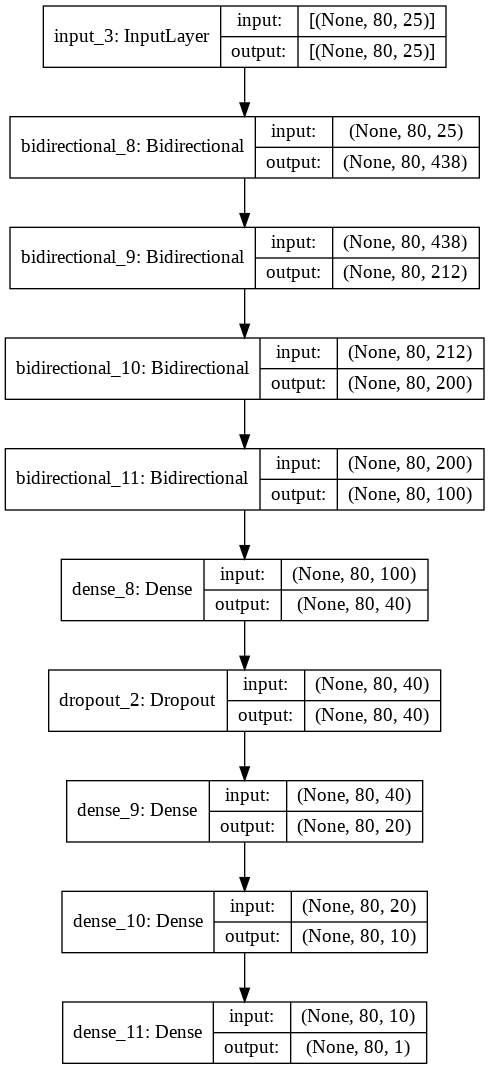

In [131]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

In [135]:
model.fit(train_x,train_y, epochs=50,batch_size=128)

Epoch 1/50
590/590 [==============================] - 41s 70ms/step - loss: 0.0139 - MAE: 0.0756
Epoch 2/50
590/590 [==============================] - 41s 70ms/step - loss: 0.0137 - MAE: 0.0753
Epoch 3/50
590/590 [==============================] - 41s 70ms/step - loss: 0.0136 - MAE: 0.0749
Epoch 4/50
590/590 [==============================] - 41s 70ms/step - loss: 0.0135 - MAE: 0.0748
Epoch 5/50
590/590 [==============================] - 41s 70ms/step - loss: 0.0134 - MAE: 0.0744
Epoch 6/50
590/590 [==============================] - 41s 70ms/step - loss: 0.0133 - MAE: 0.0742
Epoch 7/50
590/590 [==============================] - 41s 70ms/step - loss: 0.0131 - MAE: 0.0739
Epoch 8/50
590/590 [==============================] - 41s 70ms/step - loss: 0.0130 - MAE: 0.0736
Epoch 9/50
590/590 [==============================] - 41s 70ms/step - loss: 0.0129 - MAE: 0.0732
Epoch 10/50
590/590 [==============================] - 41s 70ms/step - loss: 0.0127 - MAE: 0.0729
Epoch 11/50
590/590 [========

In [137]:
result = model.predict(test_x)

In [138]:
result.shape

(50300, 80, 1)

In [139]:
result1 = result.flatten()
preds = pd.DataFrame(pt_y.inverse_transform(pd.DataFrame(result1, columns=['pressure'])),columns=['pressure'])
test = pd.read_csv('/content/drive/MyDrive/ventilator-pressure-prediction/test.csv')
id = pd.DataFrame(test['id'])

In [140]:
semi_final = pd.concat([id, preds], axis=1)

In [141]:
semi_final.head(20)

,id,pressure
0,1,6.020639
1,2,5.744071
2,3,6.555898
3,4,7.677752
4,5,8.946117
5,6,10.299911
6,7,11.320079
7,8,12.441161
8,9,13.572053
9,10,14.599267


In [142]:
semi_final.to_csv('google_submission.csv',index=False)